# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- inform: 1
- confirm_question: 2
- welcome: 8
- closing: 5
- greeting: 4


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- result: 26
- movie_series: 11
- seating: 19
- numberofkids: 15
- description: 6


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 278: {'city': 'seattle', 'theater': 'theaters all over', 'zip': '98101', 'distanceconstraints': 'south side', 'video_format': '2d', 'state': 'wa', 'starttime': 'around 6 pm', 'date': 'this evening', 'moviename': 'zootopia'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

grad_clip: -0.0001
dia_slot_val: 2
reg_cost: 0.001
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
save_check_point: 20
slot_rep: 1
max_epochs: 200
sdgtype: rmsprop
init_rnn: 0
cv_fold: 6
write_model_dir: .\checkpoints\template\07102016\
valid_test: 0
pretrained_model_path: None
check_point: 20
decay_rate: 0.999
feed_recurrence: 0
hidden_size: 100
activation_func: relu
momentum: 0.1
learning_rate: 0.001
batch_size: 16
act_set: data/dia_acts.txt
smooth_eps: 1e-08
split_method: 1
slot_set: data/slot_set.txt
eva_metric: 2
model: lstm_tanh
trained_model_path: None


# User Simulator
-------------------

### goal

In [31]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [32]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [33]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [34]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- starttime: ['10:30am', '11:10am', '1:10pm', '1:50pm', '3:45pm', '4:30pm', '5:20pm', '6:30pm', '7:15pm', '9:10pm', '10:30pm', '12:30pm', '9:30pm', '9:30', '8:40pm', '7:00pm', '9:50pm', 'none', 'before 4pm', '12:00', '1:10', '2:40', '3:50', 'around 2pm', '1:30', '4:00', 'night', '11:05am', '1:45pm', '7:20 pm', '4:35pm', '10pm', '10 pm', 'latest showing', '9:00 pm', 'around 6pm', '7:20', '9:10 pm', '8:45 pm', '8:45', '9:50 pm', 'around 3 pm', '12pm', '9:30 pm', '6pm', '9:01pm', '5:30pm', '8:00pm', '10:40pm', '2:30pm', '5:10pm', '10:00pm', '7:15 pm', '7pm', 'around 7pm', 'earliest showing', '12:45pm', '1:15pm', '12:45', '12:35pm', ' 4:05pm', ' 7:05pm', ' 9:55pm', '7:05 pm', 'after dinner', 'after 7:30pm', '10:50pm', '7:50pm', '10:20pm', '8pm', '8:20', '8:15pm', 'between 9 and 10', '10:20', 'after 7pm', '4:40 pm', 'before dinner', '7:10 pm', 'betwenn 8-10 pm', '4 pm', '4:20', '4:20pm', 'from noon to 4pm', '8:30pm', '11:00pm', '11pm', ' Matinee', '4pm to 7pm', '6:

###  Create a User

In [35]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [36]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [37]:

# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

agent_run_mode:3
16


# Dialog Manager
-------------------

In [38]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [39]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 120
num_episodes = 100

In [40]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [41]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [42]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [43]:
# def train_agent(agent = agent, num_episode = 1000, num_batches = 100, batch_size = 10, status=status, eval_every = 10, show_every = 100):
#     succ_rates = []
#     epochs = list(range(eval_every, num_episode+1, eval_every))
#     print(epochs)
#     curr_succ_rate = None
#     curr_loss      = None
#     for n_epo in epochs:
#         print("-=-=-=-=-=-= Running: {} - Success = {} | Loss = {} -=-=-=-=-=-=".format(n_epo, curr_succ_rate, curr_loss))
#         # collect experience
#         run_episodes(agent, num_episode=eval_every, status=status, record_training_data = True, is_training = True)
#         # train
#         curr_loss = agent.train(batch_size=batch_size, num_batches=num_batches, show_every = show_every)
#         # eval
#         curr_succ_rate = run_episodes(agent, num_episode=eval_every, status=status, record_training_data = False)
#         display.HTML('<h3>{}</h3> '.format("Success Rate: {}".format(curr_succ_rate)))
#         succ_rates.append(curr_succ_rate)
        
#     return {"x": epochs, 'success_rate': succ_rates}

In [ ]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(100, status)

warm_start starting ...
Warm_Start 120 epochs, success rate 0.48, ave reward 1.2, ave turns 19.2
Current experience replay buffer size 4041
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -41.54, ave turns 5.08
Train on : 4296
- cur bellman err 13.3108, experience replay pool 4296
=============== update_target_params ===============
w1_val=12.623589515686035 | w2_val=2.0465433597564697
w1_val=12.623589515686035 | w2_val=2.0465433597564697
Simulation success rate 0.0, Ave reward -41.54, Ave turns 5.08, Best success rate 0
Progress: 1 / 100, Success rate: 0 / 1 Avg reward: -40.00 Avg turns: 2.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 6396
- cur bellman err 7.3050, experience replay pool 6396
=============== update_target_params ===============
w1_val=15.706107139587402 | w2_val=3.1660385131835938
w1_val=15.706107139587402 | w

In [ ]:
draw_learning_curve(curve)

In [ ]:
draw_loss_curve(losses)

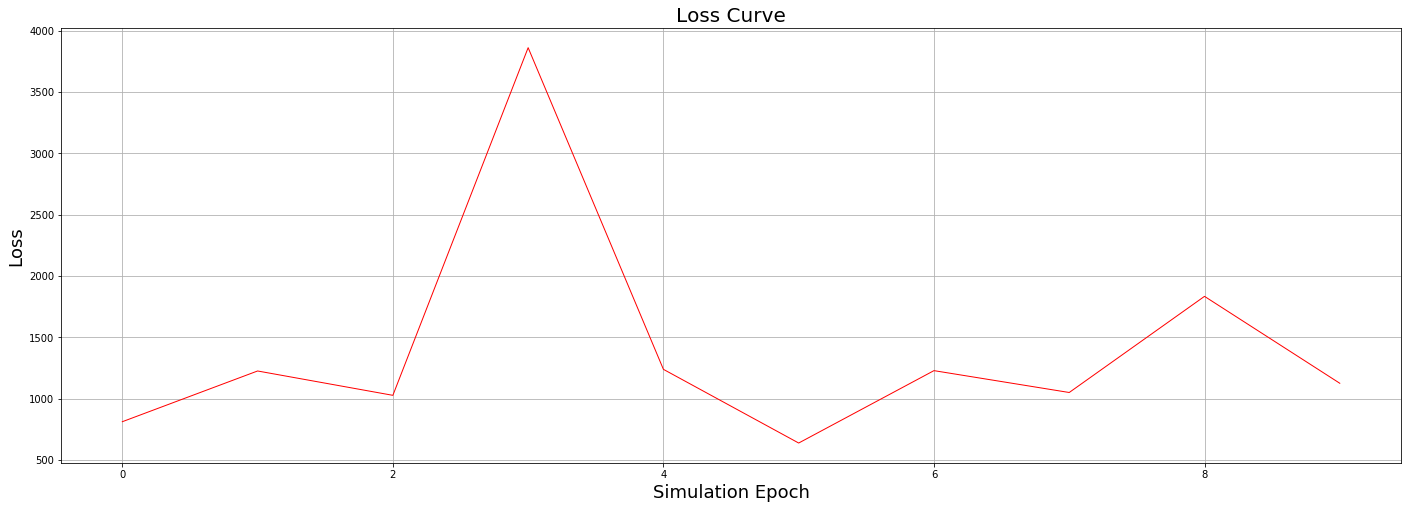

In [23]:
draw_loss_curve(losses[-10:])